In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:

class Config:
    
    def __init__(self):
        #network configure
        self.InputCh=3
        self.ScaleRatio = 2
        self.ConvSize = 3
        self.pad = 1#(self.ConvSize - 1) / 2 
        self.MaxLv = 5
        self.ChNum = [self.InputCh,64]
        for i in range(self.MaxLv-1):
            self.ChNum.append(self.ChNum[-1]*2)
        #data configure
        self.pascal = "../VOC2012/JPEGImages"
        self.bsds = "../BSR/BSDS500/data/images/"
        self.imagelist = "ImageSets/Segmentation/train.txt"
        self.BatchSize = 7
        self.Shuffle = True
        self.LoadThread = 4
        self.inputsize = [224,224]
        #partition onfigure
        self.K = 16
        #training configure
        self.init_lr = 0.05
        self.lr_decay = 0.1
        self.lr_decay_iter = 10
        self.max_iter = 15
        self.cuda_dev = 0 
        self.cuda_dev_list = "0,1"
        self.check_iter = 1000
        #Ncuts Loss configure
        self.radius = 2
        self.sigmaI = 10
        self.sigmaX = 4
        #testing configure
        self.model_tested = "./checkpoint_8_23_13_0_epoch_2000"
        #color library
        self.color_lib = []
        for r in range(0,256,128):
            for g in range(0,256,128):
                for b in range(0,256,128):
                    self.color_lib.append((r,g,b))

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as func
from torch.autograd import Function
import time
import pdb
import subprocess
import numpy as np

config = Config()
"""
class NCutsLoss(nn.Module):
    def __init__(self):
        super(NCutsLoss,self).__init__()
        self.gpu_list = []
        '''
        for i in range(torch.cuda.device_count()):
            self.gpu_list.append(torch.cuda.device(i))
# the ratio of the free space among all gpus
        self.gpu_room_list = []
        self.gpu_room_update()
        '''
    '''def gpu_room_update(self):
        self.gpu_room_list = []
        free_memory = get_gpu_memory_map()
        total_free = 0
        count_ratio = 0.0
        for _, value in free_memory.items():
            total_free+=value
        for dev in self.gpu_list:
            ratio = float(free_memory[dev])/total_free
            self.gpu_room_list.append(ratio)
            count_ratio += ratio
        if (count_ratio - 1 < 0):
            self.gpu_room_list[-1]+=1.0-count_ratio 
    '''    
            

    def forward(self, seg, padded_seg, weight,sum_weight):
        #too many values to unpack
        cropped_seg = []
        for m in torch.arange((config.radius-1)*2+1,dtype=torch.long):
            column = []
            for n in torch.arange((config.radius-1)*2+1,dtype=torch.long):
                column.append(padded_seg[:,:,m:m+seg.size()[2],n:n+seg.size()[3]].clone())
            cropped_seg.append(torch.stack(column,4))
        cropped_seg = torch.stack(cropped_seg,4)
        #for m in torch.arange(50,70,dtype=torch.long):

        #    print(m)
        #    for n in torch.arange(50,70,dtype= torch.long):
        #        print(weight[5,0,m,n])
        multi1 = cropped_seg.mul(weight)
        multi2 = multi1.sum(-1).sum(-1).mul(seg)
        multi3 = sum_weight.mul(seg)
        #print("=============================================================================")
        #for a in [0,1]:
        #    print(multi2[5,0,a*10+50:a*10+60,50:60])
        #    print(multi2[5,0,a*10+50:a*10+60,60:70])
        assocA = multi2.view(multi2.shape[0],multi2.shape[1],-1).sum(-1)
        assocV = multi3.view(multi3.shape[0],multi3.shape[1],-1).sum(-1)
        assoc = assocA.div(assocV).sum(-1)
        
        return torch.add(-assoc,config.K)
        
    '''def crop_seg(self,seg):
        cropped_seg = torch.zeros(seg.size()[0],seg.size()[1],seg.size()[2],seg.size()[3],(config.radius-1)*2+1,(config.radius-1)*2+1)
        padding_size = (config.radius,config.radius,config.radius,config.radius)
        padded_seg = torch.nn.functional.pad(seg,padding_size)
        for m in torch.arange((config.radius-1)*2+1,dtype=torch.long):
            for n in torch.arange((config.radius-1)*2+1,dtype=torch.long):
                cropped_seg[:,:,:,:,m,n].copy_(padded_seg[:,:,m:m+seg.size()[2],n:n+seg.size()[3]])
        return cropped_seg
    
def get_gpu_memory_map():
    """'''Get the current gpu usage.

    Returns
    -------
    usage: dict
        Keys are device ids as integers.
        Values are memory free as integers in MB.
    """
    result = subprocess.check_output(
        [
            'nvidia-smi', '--query-gpu=memory.free',
            '--format=csv,nounits,noheader'
        ], encoding='utf-8')
    # Convert lines into a dictionary
    gpu_memory = [int(x) for x in result.strip().split('\n')]
    gpu_memory_map = dict(zip(range(len(gpu_memory)), gpu_memory))
    return gpu_memory_map
'''        


import torch
import torch.nn as nn
import torch.nn.functional as func
from torch.autograd import Function
import time
import pdb
import subprocess
import numpy as np

def soft_n_cut_loss(seg, padded_seg, weight, sum_weight):
    #too many values to unpack
    cropped_seg = []
    for m in torch.arange((config.radius-1)*2+1,dtype=torch.long):
        column = []
        for n in torch.arange((config.radius-1)*2+1,dtype=torch.long):
            column.append(padded_seg[:,:,m:m+seg.size()[2],n:n+seg.size()[3]].clone())
        cropped_seg.append(torch.stack(column,4))
    cropped_seg = torch.stack(cropped_seg,4)
#         print(cropped_seg.shape, weight.shape)
    multi1 = cropped_seg.mul(weight)
    multi2 = multi1.sum(-1).sum(-1).mul(seg)
    multi3 = sum_weight.mul(seg)
    assocA = multi2.view(multi2.shape[0],multi2.shape[1],-1).sum(-1)
    assocV = multi3.view(multi3.shape[0],multi3.shape[1],-1).sum(-1)
    assoc = assocA.div(assocV + 1e-6).sum(-1)
    assoc = torch.add(-assoc, config.K)
    return assoc
    
# This file has been written by @AsWali and @ErwinRussel



In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as functional
import pdb
config = Config()

class Enc(nn.Module):
    def __init__(self, bias):
        super(Enc, self).__init__()
        self.feature1 = []
        self.module = []
        self.maxpool1 = []
        self.uconv1 = []
        self.module.append(
            self.add_conv_stage(config.ChNum[0],config.ChNum[1],config.ConvSize,padding=config.pad,separable=False)   
        )

        #module2-5
        for i in range(2,config.MaxLv+1):
            self.module.append(self.add_conv_stage(config.ChNum[i-1],config.ChNum[i],config.ConvSize,padding=config.pad))

        #module6-8
        for i in range(config.MaxLv-1,1,-1):
            self.module.append(self.add_conv_stage(2*config.ChNum[i],config.ChNum[i],config.ConvSize,padding=config.pad))
        #module9
        self.module.append(
            self.add_conv_stage(2*config.ChNum[1],config.ChNum[1],config.ConvSize,padding=config.pad,separable=False)
        )
        #module1-4
        for i in range(config.MaxLv-1):
            self.maxpool1.append(nn.MaxPool2d(config.ScaleRatio))
        #module5-8
        for i in range(config.MaxLv,1,-1):
            self.uconv1.append(nn.ConvTranspose2d(config.ChNum[i],config.ChNum[i-1],config.ScaleRatio,config.ScaleRatio,bias = True))
        self.predconv = nn.Conv2d(config.ChNum[1],config.K,1,bias = bias)
        self.pad = nn.ConstantPad2d(config.radius-1,0)
        self.softmax = nn.Softmax2d()
        self.module = torch.nn.ModuleList(self.module)
        self.maxpool1 = torch.nn.ModuleList(self.maxpool1)
        self.uconv1 = torch.nn.ModuleList(self.uconv1)
    def add_conv_stage(self,dim_in, dim_out, kernel_size=3, stride=1, padding=1, bias=True, separable=True):
        if separable:
            return nn.Sequential(
                nn.Conv2d(dim_in,dim_out,1,bias = bias),
                nn.Conv2d(dim_out,dim_out,kernel_size,padding = padding,groups = dim_out,bias = bias),
                nn.ReLU(),
                nn.BatchNorm2d(dim_out),
                nn.Conv2d(dim_out,dim_out,1,bias = bias),
                nn.Conv2d(dim_out,dim_out,kernel_size,padding = padding,groups = dim_out,bias = bias),
                nn.ReLU(),
                nn.BatchNorm2d(dim_out),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(dim_in,dim_out,kernel_size,padding = padding,bias = bias),
                nn.ReLU(),
                nn.BatchNorm2d(dim_out),
                nn.Conv2d(dim_out,dim_out,kernel_size,padding = padding,bias = bias),
                nn.ReLU(),
                nn.BatchNorm2d(dim_out),
            )     
    def forward(self,x):
        self.feature1 = [x]
        self.feature1.append(self.module[0](x))
        for i in range(1,config.MaxLv):
            tempf = self.maxpool1[i-1](self.feature1[-1])
            self.feature1.append(self.module[i](tempf))
        for i in range(config.MaxLv,2*config.MaxLv-2):
            tempf = self.uconv1[i-config.MaxLv](self.feature1[-1])
            tempf = torch.cat((self.feature1[2*config.MaxLv-i-1],tempf),dim=1)
            self.feature1.append(self.module[i](tempf))
        tempf = self.uconv1[-1](self.feature1[-1])
        tempf = torch.cat((self.feature1[1],tempf),dim=1)
        tempf = self.module[-1](tempf)
        tempf = self.predconv(tempf)
        self.feature2 = [self.softmax(tempf)]
        return [self.feature2[0],self.pad(self.feature2[0])]
    
class Dec(nn.Module):
    def __init__(self, bias):
        super(Dec, self).__init__()
        self.module2 = []
        self.maxpool2 = []
        self.uconv2 = []
        self.module2.append(
            self.add_conv_stage(config.K, config.ChNum[1],config.ConvSize,padding=config.pad,separable=False)   
        )
        #module2-5
        for i in range(2,config.MaxLv+1):
            self.module2.append(self.add_conv_stage(config.ChNum[i-1],config.ChNum[i],config.ConvSize,padding=config.pad))

        #module6-8
        for i in range(config.MaxLv-1,1,-1):
            self.module2.append(self.add_conv_stage(2*config.ChNum[i],config.ChNum[i],config.ConvSize,padding=config.pad))
        #module9
        self.module2.append(
            self.add_conv_stage(2*config.ChNum[1],config.ChNum[1],config.ConvSize,padding=config.pad,separable=False)
        )
        #module1-4
        for i in range(config.MaxLv-1):
            self.maxpool2.append(nn.MaxPool2d(config.ScaleRatio))
        #module5-8
        for i in range(config.MaxLv,1,-1):
            self.uconv2.append(nn.ConvTranspose2d(config.ChNum[i],config.ChNum[i-1],config.ScaleRatio,config.ScaleRatio,bias = True))
            
        self.predconv2 = nn.Conv2d(config.ChNum[1],config.ChNum[0],1,bias = bias)
        self.module2 = torch.nn.ModuleList(self.module2)
        self.maxpool2 = torch.nn.ModuleList(self.maxpool2)
        self.uconv2 = torch.nn.ModuleList(self.uconv2)
    def add_conv_stage(self,dim_in, dim_out, kernel_size=3, stride=1, padding=1, bias=True, separable=True):
        if separable:
            return nn.Sequential(
                nn.Conv2d(dim_in,dim_out,1,bias = bias),
                nn.Conv2d(dim_out,dim_out,kernel_size,padding = padding,groups = dim_out,bias = bias),
                nn.ReLU(),
                nn.BatchNorm2d(dim_out),
                nn.Conv2d(dim_out,dim_out,1,bias = bias),
                nn.Conv2d(dim_out,dim_out,kernel_size,padding = padding,groups = dim_out,bias = bias),
                nn.ReLU(),
                nn.BatchNorm2d(dim_out),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(dim_in,dim_out,kernel_size,padding = padding,bias = bias),
                nn.ReLU(),
                nn.BatchNorm2d(dim_out),
                nn.Conv2d(dim_out,dim_out,kernel_size,padding = padding,bias = bias),
                nn.ReLU(),
                nn.BatchNorm2d(dim_out),
            )
        
    def forward(self,x):
        self.feature2 = [x]
        self.feature2.append(self.module2[0](x))
        for i in range(1, config.MaxLv):
            tempf = self.maxpool2[i - 1](self.feature2[-1])
            self.feature2.append(self.module2[i](tempf))
        for i in range(config.MaxLv, 2 * config.MaxLv - 2):
            tempf = self.uconv2[i - config.MaxLv](self.feature2[-1])
            tempf = torch.cat((self.feature2[2 * config.MaxLv - i - 1], tempf), dim=1)
            self.feature2.append(self.module2[i](tempf))
       
        tempf = self.uconv2[-1](self.feature2[-1])
        tempf = torch.cat((self.feature2[1], tempf), dim=1)
        tempf = self.module2[-1](tempf)
        reconstructed_output = self.predconv2(tempf)

        return reconstructed_output

    
    
class WNet(torch.nn.Module):
    def __init__(self):
        super(WNet, self).__init__()
        bias = True
        self.Enc=Enc(bias)
        self.Dec=Dec(bias)
        
    
    def forward(self,x, returns='enc'):
        if returns=='enc':
            enc, softmax_enc = self.Enc(x)
            return enc, softmax_enc
        dec = self.Dec(x)
        return dec
        


In [5]:
from PIL import Image
import torch
import torch.utils.data as Data
import os
import glob
import numpy as np
import pdb
import math

config = Config()

class DataLoader():
    def __init__(self, datapath, datapath_masks, mode):
        self.raw_data = []
        self.masks = []  
        self.mode = mode

        file_list = glob.glob(os.path.join(datapath, '*.jpg'))
        for file_name in file_list:
            with Image.open(file_name) as image:
                if image.mode != "RGB":
                    image = image.convert("RGB")
                self.raw_data.append(np.array(image.resize((config.inputsize[0], config.inputsize[1]), Image.BILINEAR)))
                
        file_list = glob.glob(os.path.join(datapath_masks, '*.jpg'))
        for file_name in file_list:
            with Image.open(file_name) as image:
#                 if image.mode != "RGB":
#                     image = image.convert("RGB")
                self.masks.append(np.array(image.resize((config.inputsize[0], config.inputsize[1]), Image.BILINEAR)))
#         self.raw_data = np.array(self.raw_data)
        self.masks = np.array(self.masks)
                                  
#         resize and align
        self.scale()
        #normalize
        self.transfer()
        if mode == "train":
            self.dataset = self.get_dataset(self.raw_data, self.masks, self.raw_data.shape, 75)
        else:
            self.dataset = self.get_dataset(self.raw_data, self.masks, self.raw_data.shape, 75)

    def scale(self):
        for i in range(len(self.raw_data)):
            image = self.raw_data[i]
            self.raw_data[i] = np.stack((image[:, :, 0], image[:, :, 1], image[:, :, 2]), axis=0)
#             image = self.masks[i]
#             self.masks[i] = np.stack((image[:, :, 0], image[:, :, 1], image[:, :, 2]), axis=0)
#         self.masks = np.stack(self.masks, axis=0)
        self.raw_data = np.stack(self.raw_data, axis=0)

    def transfer(self):
        self.raw_data = self.raw_data.astype(np.float32)

    def torch_loader(self):
        return Data.DataLoader(
            self.dataset,
            batch_size=config.BatchSize,
            shuffle=config.Shuffle,
            num_workers=config.LoadThread,
            pin_memory=True,
        )
    """
    def cal_weight(self, raw_data, shape):
        print("calculating weights.")
        dissim = np.zeros((shape[0], shape[1], shape[2], (config.radius - 1) * 2 + 1,
                           (config.radius - 1) * 2 + 1))
        data = np.asarray(raw_data)
        padded_data = np.pad(data, ((0, 0), (config.radius - 1, config.radius - 1),
                                   (config.radius - 1, config.radius - 1)), 'constant')

        for m in range(2 * (config.radius - 1) + 1):
            for n in range(2 * (config.radius - 1) + 1):
                dissim[:, :, :, m, n] = data - padded_data[:, m:shape[1] + m, n:shape[2] + n]

        temp_dissim = np.exp(-np.power(dissim, 2).sum(1, keepdims=True) / config.sigmaI ** 2)
        dist = np.zeros((2 * (config.radius - 1) + 1, 2 * (config.radius - 1) + 1))

        for m in range(1 - config.radius, config.radius):
            for n in range(1 - config.radius, config.radius):
                if m ** 2 + n ** 2 < config.radius ** 2:
                    dist[m + config.radius - 1, n + config.radius - 1] = np.exp(-(m ** 2 + n ** 2) / config.sigmaX ** 2)

        print("weight calculated.")
        res = np.multiply(temp_dissim, dist)
        print (res.shape)
        
        return res
        """

    def cal_weight(self, raw_data, shape):
        print("calculating weights.")
        dissim = np.zeros((shape[0], shape[1], shape[2], shape[3], (config.radius - 1) * 2 + 1,
                           (config.radius - 1) * 2 + 1))
        data = np.asarray(raw_data)
        padded_data = np.pad(data, ((0, 0), (0, 0), (config.radius - 1, config.radius - 1),
                                   (config.radius - 1, config.radius - 1)), 'constant')

        for m in range(2 * (config.radius - 1) + 1):
            for n in range(2 * (config.radius - 1) + 1):
                dissim[:, :, :, :, m, n] = data - padded_data[:, :, m:shape[2] + m, n:shape[3] + n]

        temp_dissim = np.exp(-np.power(dissim, 2).sum(1, keepdims=True) / config.sigmaI ** 2)
        dist = np.zeros((2 * (config.radius - 1) + 1, 2 * (config.radius - 1) + 1))

        for m in range(1 - config.radius, config.radius):
            for n in range(1 - config.radius, config.radius):
                if m ** 2 + n ** 2 < config.radius ** 2:
                    dist[m + config.radius - 1, n + config.radius - 1] = np.exp(-(m ** 2 + n ** 2) / config.sigmaX ** 2)

        print("weight calculated.")
        res = np.multiply(temp_dissim, dist)

        return res
    
    def get_dataset(self, raw_data, masks, shape, batch_size):
        dataset = []
        for batch_id in range(0, shape[0], batch_size):
            print(batch_id)
            batch = raw_data[batch_id:min(shape[0], batch_id + batch_size)]
            batch_masks = masks[batch_id:min(shape[0], batch_id + batch_size)]

            if self.mode == "train":
                tmp_weight = self.cal_weight(batch, batch.shape)
                weight = np.array(tmp_weight)
                dataset.append(Data.TensorDataset(torch.from_numpy(batch / 256).float(),
                                                  torch.from_numpy(batch_masks / 256).float(),
                                                  torch.from_numpy(weight).float()))
                del tmp_weight
            else:
                dataset.append(Data.TensorDataset(torch.from_numpy(batch / 256).float()))
        return Data.ConcatDataset(dataset)

In [6]:
import torch.nn.functional as F
from torchvision import transforms

to_tensor = transforms.ToTensor()

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import os
from tqdm import tqdm
def calculate_pixel_accuracy(predicted_mask, true_mask):
    correct_pixels = np.sum(predicted_mask.cpu().detach().numpy() == true_mask.cpu().numpy())
    total_pixels = predicted_mask.numel()  # Use .numel() to get the total number of elements in the tensor
    pixel_accuracy = correct_pixels / total_pixels
    
    return pixel_accuracy
def reconstruction_loss(x, x_prime):
    rec_loss = torch.nn.MSELoss()(x_prime, x)
    return rec_loss
def jaccard_loss(input, target):
    smooth = 1e-6
    intersection = torch.sum(input * target)
    union = torch.sum(input) + torch.sum(target) - intersection
    jaccard = (intersection + smooth) / (union + smooth)
    loss = 1 - jaccard
    return loss
def calculate_iou(predicted_mask, true_mask):
    intersection = np.logical_and(predicted_mask.cpu().detach().numpy(), true_mask.cpu().numpy())
    union = np.logical_or(predicted_mask.cpu().detach().numpy(), true_mask.cpu().numpy())
    
    iou_score = np.sum(intersection) / np.sum(union)
    
    return iou_score

def calculate_dice_coefficient(predicted_mask, true_mask):
    intersection = np.logical_and(predicted_mask.cpu().detach().numpy(), true_mask.cpu().numpy())
    dice_coefficient = (2 * np.sum(intersection)) / (np.sum(predicted_mask.cpu().detach().numpy()) + np.sum(true_mask.cpu().numpy()))
    
    return dice_coefficient

config = Config()
os.environ["CUDA_VISIBLE_DEVICES"]=config.cuda_dev_list
if __name__ == '__main__':
    
    datapath = "/kaggle/input/dataset-train-1000/"
    datapath_masks = "/kaggle/input/dataset-masks-train-1000/"
    dataset = DataLoader(datapath, datapath_masks, "train")
    dataloader = dataset.torch_loader()

    #model = torch.nn.DataParallel(Net(True))
    model = torch.nn.DataParallel(WNet())
    model.cuda()
    #model.to(device)
    model.train()
    #optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=config.init_lr)
#     reconstr = torch.nn.MSELoss().cuda(config.cuda_dev)
#     Ncuts = NCutsLoss()
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=config.lr_decay_iter, gamma=config.lr_decay)
    n_cut_losses = []
    rec_losses = []
    for epoch in range(config.max_iter):
        print("Epoch: "+str(epoch+1))
        scheduler.step()
        Ave_Ncuts = 0.0
        Ave_Rec = 0.0
        t_load = 0.0
        t_forward = 0.0
        t_loss = 0.0
        t_backward = 0.0
        t_adjust = 0.0
        t_reset = 0.0
        t_inloss = 0.0
        epoch_losses = []
        train_iterator = tqdm(dataloader)
        n_cut_losses_item = 0
        rec_item = 0
        for x,m,w in train_iterator:
            #NCuts Loss
            x = x.cuda()
            m = m.cuda()
            w = w.cuda()
            sw = w.sum(-1).sum(-1)
            optimizer.zero_grad()
            pred,pad_pred = model(x)
            ncuts_loss = soft_n_cut_loss(pred,pad_pred,w,sw)
            ncuts_loss = ncuts_loss.sum()/config.BatchSize 
#             n_cut_loss=soft_n_cut_loss(pred,w)

#             ncuts_loss.backward(retain_graph=True)
#             optimizer.step()
#             optimizer.zero_grad()
#             criterion = nn.BCEWithLogitsLoss()
            daugman_loss = reconstruction_loss(pred[:, 0, :, :], m)
#             daugman_loss = 0
#             daugman_loss = F.binary_cross_entropy(pred[:, 0, :, :], m)
#             daugman_loss = calculate_pixel_accuracy(pred[:, 0, :, :], m)
#             daugman_loss = 1 - (2 * (pred[:, 1, :, :] * m).sum() + 1) / (pred[:, 1, :, :].sum() + m.sum() + 1)
#             daugman_loss = jaccard_loss(pred[:, 1, :, :], m)
#             daugman_loss = F.jaccard_loss(pred[:, 1, :, :], m)
#             Ave_Ncuts = (Ave_Ncuts * step + ncuts_loss.item())/(step+1)
            total_loss = ncuts_loss + (0.5 * daugman_loss)
            total_loss.backward(retain_graph=True)
#             ncuts_loss.backward(retain_graph=True)
            optimizer.step()
            optimizer.zero_grad()

            #Reconstruction Loss    
            rec = model(pred, "dec")  
            rec_loss=reconstruction_loss(x, rec)
            status = '[{0}] loss_mse = {1:0.5f} loss_ncuts = {2:0.5f}'.format(
                epoch + 1, rec_loss.item(), ncuts_loss.item())
#             Ave_Rec = (Ave_Rec * step + rec_loss.item())/(step+1)
#             total_loss = rec_loss + daugman_loss + (ncuts_loss) * 0.01 / config.K
            epoch_losses.append(total_loss.item())
#             status = '[{0}] loss_mse = {1:0.5f} loss_ncuts = {2:0.5f} loss = {3:0.5f} avg = {4:0.5f} daugman = {5:0.5f}'.format(
#                 epoch + 1, rec_loss.item(), ncuts_loss.item(), total_loss.item(), np.mean(epoch_losses), daugman_loss.item())
           
            train_iterator.set_description(status)
            rec_loss.backward()
#             total_loss.backward()
            optimizer.step()
            n_cut_losses_item = ncuts_loss.item()
            rec_losses_item = rec_loss.item()
            
            
        n_cut_losses.append(n_cut_losses_item)
        rec_losses.append(rec_losses_item)
        #t_total = t_load+t_reset+t_forward+t_loss+t_backward+t_adjust
#         print("Ncuts loss: "+str(Ave_Ncuts))#+";total time: "+str(t_total)+";forward: "+str(t_forward/t_total)+";loss: "+str(t_loss/t_total)+";backward: "+str(t_backward/t_total)+";adjust: "+str(t_adjust/t_total)+";reset&load: "+str(t_reset/t_total)+"&"+str(t_load/t_total)+"loss: "+str(t_loss)+" / "+str(t_inloss))
#         print("Reconstruction loss: "+str(Ave_Rec))
#         print("Total loss:" + str(total_loss))
        if (epoch+1)%500 == 0:
            localtime = time.localtime(time.time())
            checkname = './checkpoints'
            if not os.path.isdir(checkname):
                os.mkdir(checkname)
            checkname+='/checkpoint'
            for i in range(1,5):
                checkname+='_'+str(localtime[i])
            checkname += '_epoch_'+str(epoch+1)
            with open(checkname,'wb') as f:
                torch.save({
                    'epoch': epoch +1,
                    'state_dict': model.module.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'scheduler': scheduler.state_dict(),
                    'Ncuts': Ave_Ncuts,
                    'recon': Ave_Rec
                    },f)
            print(checkname+' saved')

0
calculating weights.
weight calculated.
75
calculating weights.
weight calculated.
150
calculating weights.
weight calculated.
225
calculating weights.
weight calculated.
300
calculating weights.
weight calculated.
375
calculating weights.
weight calculated.
450
calculating weights.
weight calculated.
525
calculating weights.
weight calculated.
600
calculating weights.
weight calculated.
675
calculating weights.
weight calculated.
750
calculating weights.
weight calculated.
825
calculating weights.
weight calculated.
900
calculating weights.
weight calculated.
975
calculating weights.
weight calculated.


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch: 1


[1] loss_mse = 0.00600 loss_ncuts = 2.64065: 100%|██████████| 143/143 [00:58<00:00,  2.44it/s]


Epoch: 2


[2] loss_mse = 0.00427 loss_ncuts = 1.63186: 100%|██████████| 143/143 [00:52<00:00,  2.70it/s]


Epoch: 3


[3] loss_mse = 0.00393 loss_ncuts = 1.55759: 100%|██████████| 143/143 [00:52<00:00,  2.70it/s]


Epoch: 4


[4] loss_mse = 0.00455 loss_ncuts = 1.54259: 100%|██████████| 143/143 [00:52<00:00,  2.70it/s]


Epoch: 5


[5] loss_mse = 0.00582 loss_ncuts = 1.44617: 100%|██████████| 143/143 [00:52<00:00,  2.71it/s]


Epoch: 6


[6] loss_mse = 0.00659 loss_ncuts = 1.38672: 100%|██████████| 143/143 [00:52<00:00,  2.71it/s]


Epoch: 7


[7] loss_mse = 0.00772 loss_ncuts = 1.49323: 100%|██████████| 143/143 [00:52<00:00,  2.70it/s]


Epoch: 8


[8] loss_mse = 0.00671 loss_ncuts = 1.31292: 100%|██████████| 143/143 [00:52<00:00,  2.70it/s]


Epoch: 9


[9] loss_mse = 0.00845 loss_ncuts = 1.34213: 100%|██████████| 143/143 [00:52<00:00,  2.71it/s]


Epoch: 10


[10] loss_mse = 0.00697 loss_ncuts = 1.28305: 100%|██████████| 143/143 [00:52<00:00,  2.71it/s]


Epoch: 11


[11] loss_mse = 0.00768 loss_ncuts = 1.26761: 100%|██████████| 143/143 [00:52<00:00,  2.71it/s]


Epoch: 12


[12] loss_mse = 0.00700 loss_ncuts = 1.29837: 100%|██████████| 143/143 [00:52<00:00,  2.71it/s]


Epoch: 13


[13] loss_mse = 0.00651 loss_ncuts = 1.27616: 100%|██████████| 143/143 [00:52<00:00,  2.70it/s]


Epoch: 14


[14] loss_mse = 0.00676 loss_ncuts = 1.27790: 100%|██████████| 143/143 [00:52<00:00,  2.70it/s]


Epoch: 15


[15] loss_mse = 0.00669 loss_ncuts = 1.27421: 100%|██████████| 143/143 [00:52<00:00,  2.70it/s]


In [8]:
"""
i = 0
for name in glob.glob("/kaggle/input/eye-iris-casia-diabetes/train/eye/*[0-9].JPG", recursive=True):
    iris = Image.open(name)
    eye_iris_casia_diabetes = '/kaggle/working/eye-iris-casia-diabetes/' 
    os.makedirs(eye_iris_casia_diabetes, exist_ok=True)
    Image.fromarray(iris).save(eye_iris_casia_diabetes + "_"+str(i)+".jpg")
    i+=1
    if i == 500:
        break
        """


'\ni = 0\nfor name in glob.glob("/kaggle/input/eye-iris-casia-diabetes/train/eye/*[0-9].JPG", recursive=True):\n    iris = Image.open(name)\n    eye_iris_casia_diabetes = \'/kaggle/working/eye-iris-casia-diabetes/\' \n    os.makedirs(eye_iris_casia_diabetes, exist_ok=True)\n    Image.fromarray(iris).save(eye_iris_casia_diabetes + "_"+str(i)+".jpg")\n    i+=1\n    if i == 500:\n        break\n        '

In [9]:
"""import os

path = '/kaggle/input/eye-iris-casia-diabetes/train/eye/'
num_images = len([f for f in os.listdir(path) if f.endswith('.JPG') or f.endswith('.png')])  # подсчет изображений с расширениями .jpg и .png

print(f'Количество изображений в папке: {num_images}')"""

"import os\n\npath = '/kaggle/input/eye-iris-casia-diabetes/train/eye/'\nnum_images = len([f for f in os.listdir(path) if f.endswith('.JPG') or f.endswith('.png')])  # подсчет изображений с расширениями .jpg и .png\n\nprint(f'Количество изображений в папке: {num_images}')"

0
75
150
225
300
375
450
525
600
Step1


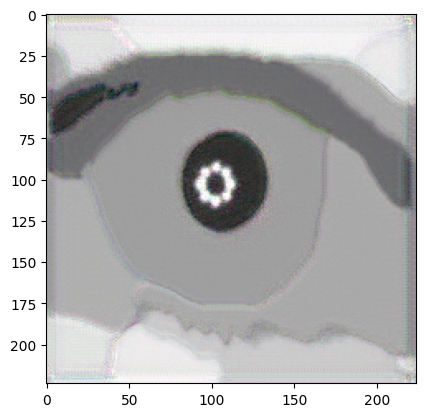

Step2
Step3
Step4
Step5
Step6
Step7
Step8
Step9
Step10
Step11


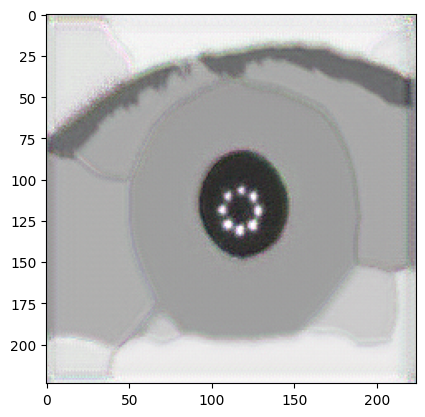

Step12
Step13
Step14
Step15
Step16
Step17
Step18
Step19
Step20
Step21


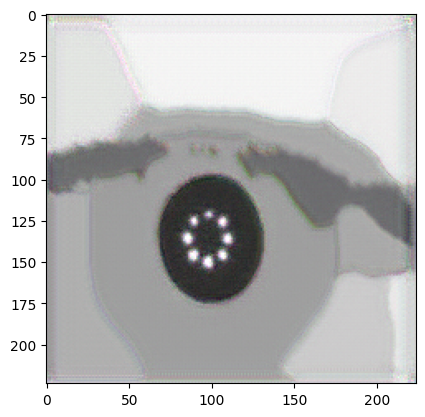

Step22
Step23
Step24
Step25
Step26
Step27
Step28
Step29
Step30
Step31


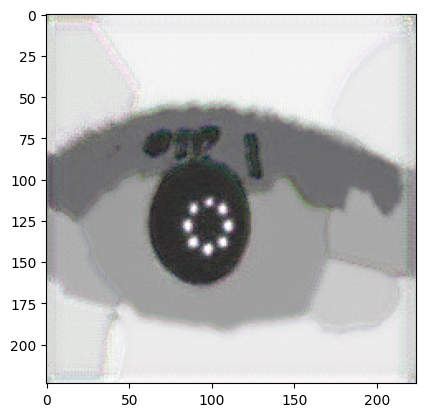

Step32
Step33
Step34
Step35
Step36
Step37
Step38
Step39
Step40
Step41


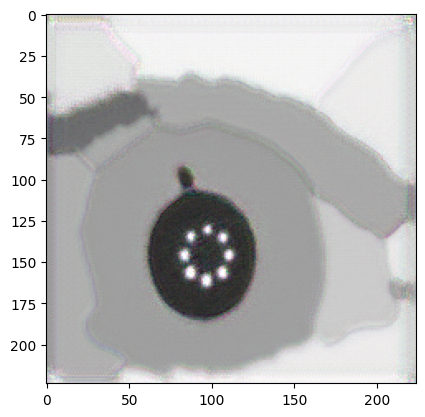

Step42
Step43
Step44
Step45
Step46
Step47
Step48
Step49
Step50
Step51


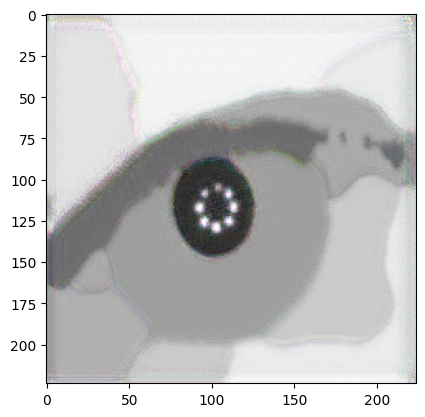

Step52
Step53
Step54
Step55
Step56
Step57
Step58
Step59
Step60
Step61


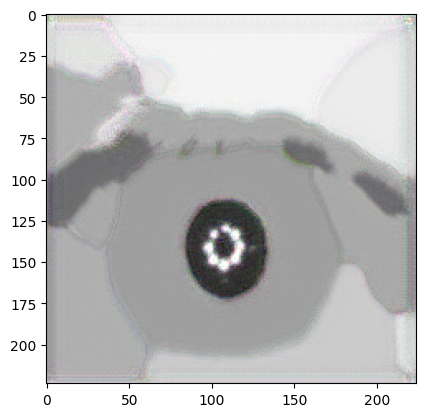

Step62
Step63
Step64
Step65
Step66
Step67
Step68
Step69
Step70
Step71


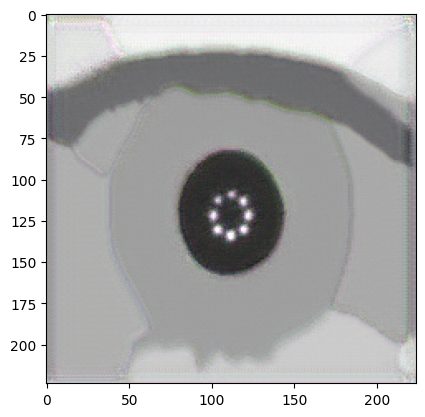

Step72
Step73
Step74
Step75
Step76
Step77
Step78
Step79
Step80
Step81


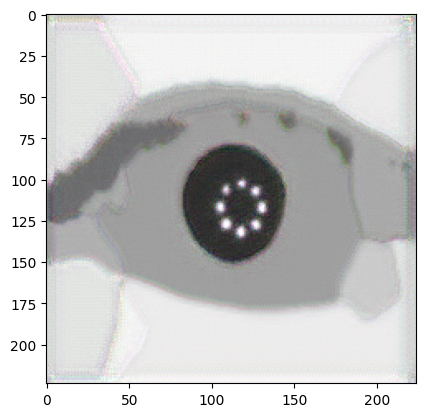

Step82
Step83
Step84
Step85
Step86
Step87
Step88
Step89
Step90
Step91


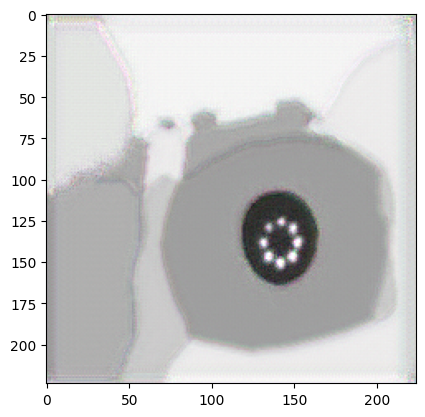

Step92


In [10]:
import torch
import numpy as np

import time
import os
import torchvision
import pdb
from PIL import Image

config = Config()
os.environ["CUDA_VISIBLE_DEVICES"]=config.cuda_dev_list
if __name__ == '__main__':
    datapath = "/kaggle/input/casia-interval-2000-2638"
    dataset = DataLoader(datapath, datapath, "test")
    dataloader = dataset.torch_loader()

    model.eval()
    optimizer = torch.optim.SGD(model.parameters(),lr = config.init_lr)
    #optimizer
    #with open(config.model_tested,'rb') as f:
        #para = torch.load(f,"cuda:0")
        #model.load_state_dict(para['state_dict'])
    show = 0
    for step,[x] in enumerate(dataloader):
        print('Step' + str(step+1))
            #NCuts Loss
                    
        x = x.cuda()
        pred,pad_pred = model(x)
        seg = (pred.argmax(dim = 1)).cpu().detach().numpy()
        x = x.cpu().detach().numpy()*255
        x = np.transpose(x.astype(np.uint8),(0,2,3,1))
        # Перед строкой, где возникает ошибка
        #print("Unique values in 'seg':", np.unique(seg))
        #print("shape Unique'seg':", np.unique(seg).shape)
        # Это поможет вам понять, какие значения присутствуют в 'seg'
        # Создайте цветовую карту динамически в зависимости от количества уникальных значений в 'seg'
        unique_values = np.unique(seg)
        #config.color_lib = [(np.random.randint(0, 256), np.random.randint(0, 256), np.random.randint(0, 256)) for _ in range(len(unique_values))]
        config.color_lib = []
        #print("shape'seg':", seg.shape)

        for r in range(0, 256, 64):
            for g in range(0, 256, 64):
                for b in range(0, 256, 64):
                    config.color_lib.append((r, g, b))
        rec = model(pred, "dec")
        img_transposed = np.transpose(rec[0,:,:,:].cpu().detach().numpy(), (1, 2, 0))
        if (show % 10 == 0):
            plt.imshow(img_transposed)
            plt.show()
            
        show += 1
        color_map = lambda c: config.color_lib[c]
        vectorized_color_map = np.vectorize(color_map)
        seg = np.moveaxis(np.array(vectorized_color_map(seg)), 0, -1).astype(np.uint8)
        directory_input_ = '/kaggle/working/input_/' 
        os.makedirs(directory_input_, exist_ok=True)   
        directory_overlay_ = '/kaggle/working/overlay_/' 
        os.makedirs(directory_overlay_, exist_ok=True)
        directory_seg_ = '/kaggle/working/seg_/' 
        os.makedirs(directory_seg_, exist_ok=True)
        directory_enc_ = '/kaggle/working/enc_/' 
        os.makedirs(directory_enc_, exist_ok=True)
        for i in range(seg.shape[0]):
            input_x = cv2.resize(x[i], (320, 280))
            seg_x = cv2.resize(seg[i, :, :], (320, 280))
            alpha = 0.5

            # Наложение изображений с прозрачностью
            overlay = cv2.addWeighted(seg_x, alpha, input_x, 1 - alpha, 0)
#             Image.fromarray(rec).save(directory_enc_ +str(step+1)+"_"+str(i)+".jpg")
            #img_transposed.save(directory_enc_ +str(step+1)+"_"+str(i)+".jpg")
            Image.fromarray(input_x).save(directory_input_ +str(step+1)+"_"+str(i)+".jpg")
            Image.fromarray(seg_x).save(directory_seg_+str(step+1)+"_"+str(i)+".jpg")
            Image.fromarray(overlay).save(directory_overlay_+str(step+1)+"_"+str(i)+".jpg")




        

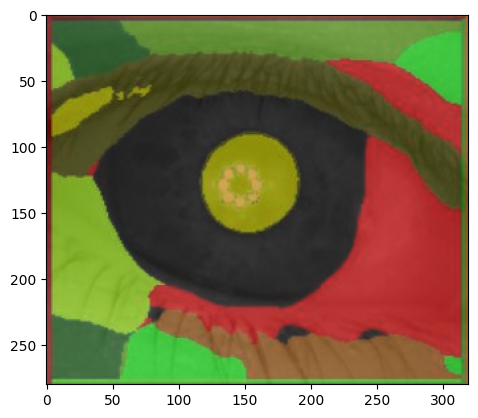

In [11]:
import matplotlib.pyplot as plt
import cv2
img_path = "//kaggle/working/seg_/45_1.jpg"
iris = cv2.imread("/kaggle/working/seg_/1_0.jpg", 1)
input_iris = cv2.imread("/kaggle/working/input_/1_0.jpg", 1)
# Прозрачность (alpha) для первого изображения
alpha = 0.7

# Наложение изображений с прозрачностью
overlay = cv2.addWeighted(iris, alpha, input_iris, 1 - alpha, 0)
plt.imshow(overlay)
plt.show()


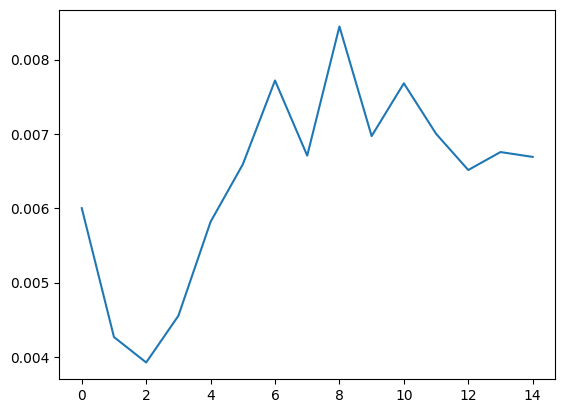

In [12]:
plt.plot([i for i in range(len(rec_losses))], rec_losses)
plt.show()

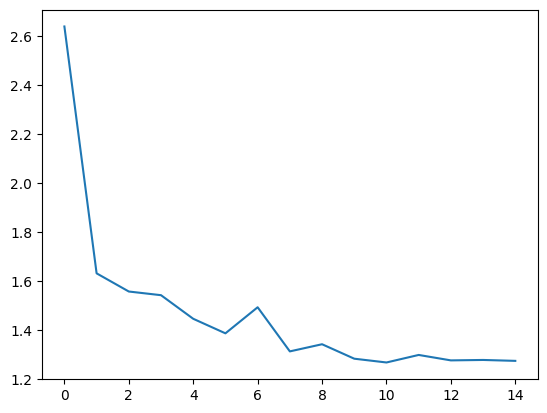

In [13]:
plt.plot([i for i in range(len(n_cut_losses))], n_cut_losses)
plt.show()

In [14]:
 import shutil


In [15]:
shutil.make_archive("/kaggle/working/input_archive", 'zip', "/kaggle/working/input_")
shutil.make_archive("/kaggle/working/seg_archive", 'zip', "/kaggle/working/seg_")
shutil.make_archive("/kaggle/working/enc_archive", 'zip', "/kaggle/working/enc_")
shutil.make_archive("/kaggle/working/overlay_archive", 'zip', "/kaggle/working/overlay_")

'/kaggle/working/overlay_archive.zip'

In [16]:
import torch
from torch import nn


class CRF(nn.Module):
    def __init__(self, num_nodes, iteration=10):
        """Initialize the CRF module

        Args:
            num_nodes: int, number of nodes/patches within the fully CRF
            iteration: int, number of mean field iterations, e.g. 10
        """
        super(CRF, self).__init__()
        self.num_nodes = num_nodes
        self.iteration = iteration
        self.W = nn.Parameter(torch.zeros(1, num_nodes, num_nodes))

    def forward(self, feats, logits):
        """Performing the CRF. Algorithm details is explained below:

        Within the paper, I formulate the CRF distribution using negative
        energy and cost, e.g. cosine distance, to derive pairwise potentials
        following the convention in energy based models. But for implementation
        simplicity, I use reward, e.g. cosine similarity to derive pairwise
        potentials. So now, pairwise potentials would encourage high reward for
        assigning (y_i, y_j) with the same label if (x_i, x_j) are similar, as
        measured by cosine similarity, pairwise_sim. For

        pairwise_potential_E = torch.sum(
            probs * pairwise_potential - (1 - probs) * pairwise_potential,
            dim=2, keepdim=True
        )

        This is taking the expectation of pairwise potentials using the current
        marginal distribution of each patch being tumor, i.e. probs. There are
        four cases to consider when taking the expectation between (i, j):

        1. i=T,j=T; 2. i=N,j=T; 3. i=T,j=N; 4. i=N,j=N

        probs is the marginal distribution of each i being tumor, therefore
        logits > 0 means tumor and logits < 0 means normal. Given this, the
        full expectation equation should be:

        [probs * +pairwise_potential] + [(1 - probs) * +pairwise_potential] +
                    case 1                            case 2
        [probs * -pairwise_potential] + [(1 - probs) * -pairwise_potential]
                    case 3                            case 4

        positive sign rewards logits to be more tumor and negative sign rewards
        logits to be more normal. But because of label compatibility, i.e. the
        indicator function within equation 3 in the paper, case 2 and case 3
        are dropped, which ends up being:

        probs * pairwise_potential - (1 - probs) * pairwise_potential

        In high level speaking, if (i, j) embedding are different, then
        pairwise_potential, as computed as cosine similarity, would approach 0,
        which then as no affect anyway. if (i, j) embedding are similar, then
        pairwise_potential would be a positive reward. In this case,
        if probs -> 1, then pairwise_potential promotes tumor probability;
        if probs -> 0, then -pairwise_potential promotes normal probability.

        Args:
            feats: 3D tensor with the shape of
            [batch_size, num_nodes, embedding_size], where num_nodes is the
            number of patches within a grid, e.g. 9 for a 3x3 grid;
            embedding_size is the size of extracted feature representation for
            each patch from ResNet, e.g. 512
            logits: 3D tensor with shape of [batch_size, num_nodes, 1], the
            logit of each patch within the grid being tumor before CRF

        Returns:
            logits: 3D tensor with shape of [batch_size, num_nodes, 1], the
            logit of each patch within the grid being tumor after CRF
        """
        feats_norm = torch.norm(feats, p=2, dim=2, keepdim=True)
        pairwise_norm = torch.bmm(feats_norm,
                                  torch.transpose(feats_norm, 1, 2))
        pairwise_dot = torch.bmm(feats, torch.transpose(feats, 1, 2))
        # cosine similarity between feats
        pairwise_sim = pairwise_dot / pairwise_norm
        # symmetric constraint for CRF weights
        W_sym = (self.W + torch.transpose(self.W, 1, 2)) / 2
        pairwise_potential = pairwise_sim * W_sym
        unary_potential = logits.clone()

        for i in range(self.iteration):
            # current Q after normalizing the logits
            probs = torch.transpose(logits.sigmoid(), 1, 2)
            # taking expectation of pairwise_potential using current Q
            pairwise_potential_E = torch.sum(
                probs * pairwise_potential - (1 - probs) * pairwise_potential,
                dim=2, keepdim=True)
            logits = unary_potential + pairwise_potential_E

        return logits

    def __repr__(self):
        return 'CRF(num_nodes={}, iteration={})'.format(
            self.num_nodes, self.iteration
        )

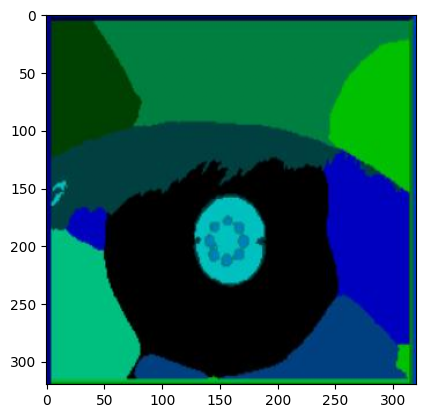

NameError: name 'crf_fit_predict' is not defined

In [17]:
from torchvision import datasets, transforms
from cv2 import imread, imwrite, resize
def show_image(image):
    img = image.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    plt.show()
transform = transforms.Compose([transforms.Resize((320, 320)),
                                transforms.ToTensor()])
img = Image.open(img_path).convert('RGB')
x = transform(img)[None, :, :, :]
enc, dec = model(x)
show_image(x[0])
# plt.imshow(torch.argmax(enc, dim=1)[0].cpu().detach().numpy())
# plt.show()
show_image(crf_fit_predict(x[0], img))

In [ ]:
from pydensecrf.utils import unary_from_softmax, create_pairwise_bilateral

def load_enc_crf(img_path):
    img = Image.open(img_path)
    x = transform(img)[None, :, :, :]
    enc, dec = model(x)
    segment = enc[0, :, :, :].detach()
    orimg = imread(img_path)
    img = resize(orimg, (320, 320))
    return np.argmax(dense_crf(img, segment.cpu().detach().numpy()), axis=0)

segment_predict = load_enc_crf(img_path)
plt.imshow(segment_predict)

In [ ]:
directory = '/kaggle/working/input_'

# Получение списка файлов в директории
files = os.listdir(directory)

# Удаление файлов из директории
for file in files:
    os.remove(os.path.join(directory, file))

In [ ]:
kaggle.api.dataset_download_files(dataset_name, path='.', unzip=True)


In [ ]:
"""
import os

directory_path = "/kaggle/working/"  # Укажите путь к вашей директории

# Получаем список файлов в директории
file_list = os.listdir(directory_path)

# Проходим по списку и удаляем каждый файл
for file_name in file_list:
    file_path = os.path.join(directory_path, file_name)
    try:
        if os.path.isfile(file_path):
            os.remove(file_path)
        else:
            print(f"Skipping {file_path} as it is not a file.")
    except Exception as e:
        print(f"Error deleting {file_path}: {e}")

print("Files deleted successfully.")
"""
